### 準備

In [1]:
import torch
from tqdm import tqdm
from stable_baselines3 import PPO

from stable_baselines3.common.callbacks import EvalCallback

In [2]:
import os
import sys
sys.path.append(os.path.pardir)

In [3]:
from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *
from cpm_torch.CPMEnv import *
from cpm_torch.Training.CPM_PPO import *
from cpm_torch.Training.CPM_Policy import *

error: XDG_RUNTIME_DIR not set in the environment.


In [4]:
from datetime import datetime

def create_timestamped_results_dir(base_dir="results/PPOs"):
    """
    Creates a timestamped directory within the base results directory.
    
    Args:
        base_dir (str): Base directory where the timestamped folder will be created
        
    Returns:
        str: Path to the created directory
    """
    # Create the base directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create a timestamp string
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create the full path
    result_dir = os.path.join(base_dir, timestamp)
    
    # Create the directory
    os.makedirs(result_dir)
    
    print(f"Created results directory: {result_dir}")
    return result_dir


is_continue = False  # Set to True if you want to continue training from a previous model

if is_continue:
    result_dir = "results/PPOs/20250513-041642"  # Example directory for demonstration
    model_dir = os.path.join(result_dir, "recent_model")
else:
    result_dir = create_timestamped_results_dir()

Created results directory: results/PPOs/20250522-004247


### ハイパーパラメータ

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=100.0,  # 目標細胞面積 A_0
    L_0=52.0,  # 目標細胞周囲長 L_0
    T=1.0,  # 温度パラメータ T
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (256, 256), 'dim': 2, 'height': 256, 'width': 256, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 100.0, 'L_0': 52.0, 'T': 1.0}


### 環境

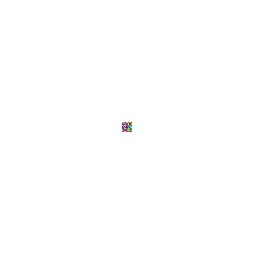

In [6]:
env = CPMEnv(config)  # CPM環境のインスタンスを作成
env.reset()  # 環境をリセット
env.render()  # 環境を描画

In [7]:
eval_freq = 10000
best_model_save_path = os.path.join(result_dir, "best_model")
n_eval_episodes = 10

eval_callback = EvalCallback(
    env,    # 評価環境
    log_path='path/to/log',
    eval_freq=eval_freq,
    deterministic=True,
    render=True,
    best_model_save_path=best_model_save_path,
    n_eval_episodes=n_eval_episodes
)

In [ ]:
model = PPO(CPMPolicy, env, tensorboard_log=os.path.join(result_dir), verbose=1, n_epochs=50)
# パラメータ数を表示
print(f"Number of parameters: {sum(p.numel() for p in model.policy.parameters())}")
for name, param in model.policy.named_parameters():
    print(f"{name}: {param.size()}")
print(model.policy)
model.learn(total_timesteps=1000000, progress_bar=True)  # 学習を実行

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Number of parameters: 885089574
CPMPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (policy_net): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (value_net): Sequential(
    (0): UNet(
      (downs): ModuleList(
        (0): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): R

/root/.pyenv/versions/3.9.17/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyboardInterrupt: 